In [1]:
import pandas as pd
import numpy as np
import akshare as ak
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
plt.style.use("ggplot")
plt.rcParams['font.family'] = 'SimHei'

## Data Preparation
* We only save the final combined data for simplicity, steps taken to get the final data:
    * use all stocks in sohu 新能源车 sector as base universe
    * merge with universe in data_cur and data_pf
    * get daily price/volume data for all stocks in universe
    * merge with 同花顺行业代码
    * merge with 新浪财经-财务指标
    * also we get the index price data for CS新能车

In [4]:
data = pd.read_csv("data.csv", index_col=0)

In [5]:
data["ric"] = data["ric"].apply(lambda x: str(x).rjust(6, "0"))

In [6]:
data.head()

,open,close,high,low,amount,volume,振幅,涨跌幅,涨跌额,turnover,...,负债与所有者权益比率(%),资本固定化比率(%),产权比率(%),资产负债率(%),总资产(元),经营现金净流量对销售收入比率(%),资产的经营现金流量回报率(%),经营现金净流量与净利润的比率(%),经营现金净流量对负债比率(%),现金流量比率(%)
date,,,,,,,,,,,,,,,,,,,,,
2022-04-01,221.48,223.34,224.00,212.90,27562.0,400636064.0,4.96,-0.16,-0.36,1.79,...,70.1723,86.5288,67.5675,41.2360,8.171656e+09,-0.1066,-0.0204,-0.9669,-0.0495,-5.5364
2022-04-01,69.59,69.08,69.71,68.30,13979.0,30924877.0,2.02,-0.99,-0.69,0.79,...,94.9855,70.9743,91.2972,48.7141,1.037718e+10,0.0199,0.0052,0.4029,0.0108,1.4528
2022-04-01,11.44,10.93,11.44,10.88,253297.0,162879480.0,4.81,-6.10,-0.71,5.92,...,68.7034,70.5655,58.4901,40.7244,1.395413e+09,-0.0842,-0.0241,-1.3605,-0.0592,-7.6742
2022-04-01,26.14,25.78,26.25,25.73,20465.0,28758677.0,1.97,-2.13,-0.56,1.46,...,34.4873,39.8722,32.3885,25.6435,1.291971e+09,-0.5190,-0.0268,NaN,-0.1043,-11.2924
2022-04-01,18.85,18.80,18.85,18.50,10975.0,20281914.0,1.87,0.27,0.05,2.63,...,20.9064,56.6860,18.5540,17.2914,3.393841e+09,0.1626,0.0214,2.0291,0.1239,13.9582


In [7]:
cur = pd.read_excel("data_cur.xlsx")
pf = pd.read_excel("data_pf.xlsx")

In [8]:
cur["ric"] = cur["ric"].apply(lambda x: x.split("/")[-1].split(".")[0])
pf["ric"] = pf["ric"].apply(lambda x: x.split("/")[-1].split(".")[0])

In [9]:
first_cur = cur[cur["date"] == "4/28/2023"]
first_pf = pf[pf["asof_datetime"] == "5/26/2023"]

second_cur = cur[cur["date"] == "10/31/2023"]
second_pf = pf[pf["asof_datetime"] == "11/24/2023"]

In [10]:
first_addition = [x for x in first_pf["ric"] if x not in first_cur["ric"].tolist()]
first_deletion = [x for x in first_cur["ric"] if x not in first_pf["ric"].tolist()]

second_addition = [x for x in second_pf["ric"] if x not in second_cur["ric"].tolist()]
second_deletion = [x for x in second_cur["ric"] if x not in second_pf["ric"].tolist()]

In [11]:
first_weight_merge = pd.merge(
    first_cur[["ric", "cap_factor", "shares_out", "fif", "local_price", "idx_weight"]],
    first_pf[
        [
            "ric",
            "status",
            "proforma_shares",
            "proforma_fif",
            "proforma_cap",
            "proforma_paf",
            "local_price",
            "idx_weight",
        ]
    ],
    on="ric",
)

In [12]:
new_energy_index = pd.read_excel("399976perf.xlsx")

In [13]:
new_energy_index = new_energy_index[
    ["日期Date", "收盘Close", "成交金额（亿元）Turnover"]
].rename(columns={"日期Date": "date", "收盘Close": "close", "成交金额（亿元）Turnover": "volume"})

In [14]:
new_energy_index["date"] = pd.to_datetime(new_energy_index["date"], format="%Y%m%d")

In [15]:
new_energy_index = new_energy_index.set_index("date")

In [16]:
index_ret = new_energy_index["close"].pct_change()

In [17]:
from sklearn.cluster import KMeans

In [18]:
sub_data = data.loc["2022-04-28":"2023-04-28"]
sub_ret = (
    sub_data.reset_index().set_index(["date", "ric"])["close"].unstack().pct_change()
)

In [19]:
sub_ret = sub_ret[sub_ret.count()[sub_ret.count() > 200].index].dropna()

In [20]:
kmean_score = {}
for i in range(3, 8):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(sub_ret.T)
    kmean_score[i] = kmeans.score(sub_ret.T)

<Axes: >

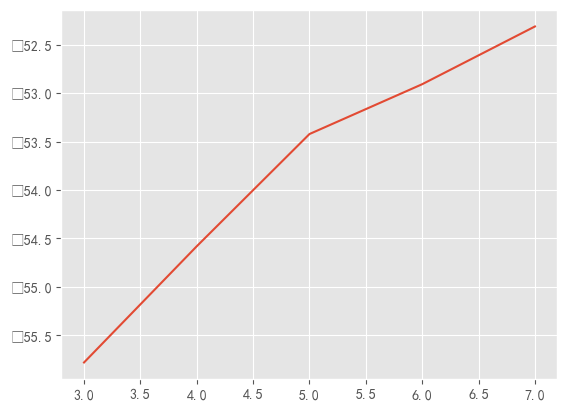

In [21]:
pd.Series(kmean_score).plot()  # set to 5

In [22]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(sub_ret.T)

KMeans(n_clusters=5)

In [23]:
labels = pd.Series(kmeans.predict(sub_ret.T), index=sub_ret.columns)

In [24]:
financial_cols = [
    "摊薄每股收益(元)",
    "加权每股收益(元)",
    "每股收益_调整后(元)",
    "每股净资产_调整前(元)",
    "每股净资产_调整后(元)",
    "每股经营性现金流(元)",
    "每股资本公积金(元)",
    "每股未分配利润(元)",
    "总资产利润率(%)",
    "主营业务利润率(%)",
    "总资产净利润率(%)",
    "成本费用利润率(%)",
    "营业利润率(%)",
    "主营业务成本率(%)",
    "销售净利率(%)",
    "股本报酬率(%)",
    "净资产报酬率(%)",
    "资产报酬率(%)",
    "三项费用比重",
    "非主营比重",
    "主营利润比重",
    "主营业务利润(元)",
    "净资产收益率(%)",
    "加权净资产收益率(%)",
    "扣除非经常性损益后的净利润(元)",
    "主营业务收入增长率(%)",
    "净利润增长率(%)",
    "净资产增长率(%)",
    "总资产增长率(%)",
    "应收账款周转率(次)",
    "应收账款周转天数(天)",
    "存货周转天数(天)",
    "存货周转率(次)",
    "总资产周转率(次)",
    "总资产周转天数(天)",
    "流动资产周转率(次)",
    "流动资产周转天数(天)",
    "股东权益周转率(次)",
    "流动比率",
    "速动比率",
    "现金比率(%)",
    "利息支付倍数",
    "股东权益比率(%)",
    "负债与所有者权益比率(%)",
    "资本固定化比率(%)",
    "产权比率(%)",
    "资产负债率(%)",
    "总资产(元)",
    "经营现金净流量对销售收入比率(%)",
    "资产的经营现金流量回报率(%)",
    "经营现金净流量与净利润的比率(%)",
    "经营现金净流量对负债比率(%)",
    "现金流量比率(%)",
]

In [25]:
data[financial_cols] = data[financial_cols].astype("float")

## Feature Construction
We propose the following categories of features to predict addition/deletion:
1. financial statistics reflecting firm profitability, growth and leverage, etc.
2. annual average market cap itself, and momentum of market cap, etc.
3. stock return correlation with the CS新能车 return, which is an approximate of current in/not in the index
4. stock turnover ratio as a measure of liquidity
5. market cap to the sector mean market cap, certain stock might belong in a sector with general smaller capital but the index committee wants to make the index more comprehansive.
6. similar market cap ratio, just change the sector mean to KMeans cluster mean
7. market cap rank within sector/KMeans cluster, reflecting relative market cap within the group
8. stock return correlation to the sector mean return, similar idea as 3 just more specific
9. dominace factor, the sum of absoluate value for stock return correlations. high dominace factor means such stock is more 'influential' in the universe
10. price momentum to testify short-term factor performance

Based on the feature importance from lightGBM, only features in categories 1, 2, 7 and 9 were selected. 

In [26]:
def prepare_features(time="first"):
    if time == "first":
        sub_data = data.loc["2022-04-28":"2023-04-28"]
    else:
        sub_data = data.loc["2022-10-31":"2023-10-31"]
    sub_ret = (
        sub_data.reset_index()
        .set_index(["date", "ric"])["close"]
        .unstack()
        .pct_change()
    )
    sub_features = pd.concat(
        [
            sub_data.groupby("ric")["mktcap"].mean(),
            sub_ret.corrwith(index_ret).rename("corr"),
        ],
        axis=1,
    )
    sub_features = sub_features.replace([np.inf, -np.inf], np.nan)
    sub_features = sub_features.dropna()
    sub_ret = sub_ret[sub_ret.count()[sub_ret.count() > 200].index].dropna()
    sub_data = sub_data[sub_data["ric"].isin(sub_ret.columns)]

    mktcap = sub_data.groupby("ric")["mktcap"].mean()

    # financials
    sub_features[financial_cols] = sub_data.groupby("ric")[financial_cols].mean()

    # latest month index corr
    sub_features["corr_month"] = sub_ret.iloc[-21:].corrwith(index_ret)

    # average liquidity
    sub_features["liquidity"] = sub_data.groupby("ric")["turnover"].mean()
    sub_features["liquidity_month"] = (
        sub_data.set_index("month")
        .groupby(["ric"])
        .apply(lambda x: x["turnover"].ewm(12).mean().iloc[-1])
    )

    # mktcap ratio to the sector mean
    industry_mean = sub_data.groupby("sector")["mktcap"].mean().rename("sector_mean")
    sub_data = sub_data.merge(industry_mean, on="sector", how="left")
    sub_features["mktcap_ratio_to_sector"] = (
        mktcap / sub_data.groupby("ric")["sector_mean"].mean()
    )

    # mktcap rank within sector
    sector_mktcap = pd.concat(
        [
            sub_data.set_index("ric")["sector"].drop_duplicates().rename("label"),
            mktcap.rename("mktcap"),
        ],
        axis=1,
    )
    sub_features["mktcap_sector_rank"] = sector_mktcap.groupby("label")["mktcap"].rank()

    # return correlation to the sector average
    corr_to_sector_mean = pd.Series(index=sub_ret.columns)
    for s in sub_data["sector"].unique():
        sector_stocks = sub_data[sub_data["sector"] == s]["ric"].unique()
        cap_weight_sector_mean = (sub_ret[sector_stocks] * mktcap[sector_stocks]).sum(
            1
        ) / mktcap[sector_stocks].sum()
        corr_to_sector_mean[sector_stocks] = sub_ret[sector_stocks].corrwith(
            corr_to_sector_mean
        )
    sub_features["corr_to_sector_mean"] = corr_to_sector_mean

    # mktcap increase
    sub_features["mktcap_ema"] = (
        sub_data.set_index("month")
        .groupby(["ric"])
        .apply(lambda x: x["mktcap"].ewm(12).mean().iloc[-1])
    )
    sub_features["mktcap_mom"] = (
        sub_data.set_index("month")
        .groupby(["ric"])
        .apply(lambda x: x["mktcap"].iloc[-1] - x["mktcap"].ewm(12).mean().iloc[-1])
    )

    # industry dominance
    sub_features["dominance"] = sub_ret.corr().abs().sum()

    # price momentum
    sub_features["ret_ema"] = sub_ret.ewm(21).mean().iloc[-1]
    sub_features["ret_mom"] = sub_ret.iloc[-1] - sub_features["ret_ema"]

    # mktcap rank within kmean cluster
    kmeans_mktcap = pd.concat([labels.rename("label"), mktcap.rename("mktcap")], axis=1)
    sub_features["mktcap_kmeans_rank"] = kmeans_mktcap.groupby("label")["mktcap"].rank()

    rank_columns = [x for x in sub_features.columns if "rank" not in x]

    sub_features[rank_columns] = sub_features[rank_columns].rank()
    if time == "first":
        sub_features["y"] = (first_pf.set_index("ric")["idx_weight"] > 0) * 1
    else:
        sub_features["y"] = (second_pf.set_index("ric")["idx_weight"] > 0) * 1
    sub_features = sub_features.fillna(0)

    return sub_features

In [27]:
first_feature = prepare_features("first").dropna()
second_feature = prepare_features("second").dropna()

## Addition/Deletion Prediction Model

A natural way to predict this is using a binary classification method, namely 'in the index'/'not in the index'. After we get the prediction, we can compare with the current composition to find out addition/deletion.

We applied logistic regression and lightGBM for prediction. Using the first rebalance as train set and the second as test. LightGBM is better than penalized logistic in both insample and out-of-sample score.

More summary for feature importance and dependency can be found below.

In [28]:
from sklearn.linear_model import LogisticRegressionCV
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV

In [29]:
param_space = {
    "boosting_type": ["gbdt", "dart", "goss"],
    "num_leaves": [20, 30, 40, 50],
    "max_depth": [-1, 5, 10, 15],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [50, 100, 200],
    "subsample": [0.6, 0.7, 0.8, 0.9],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9],
    "reg_alpha": [0.0, 0.1, 0.5, 1.0],
    "reg_lambda": [0.0, 0.1, 0.5, 1.0],
    "min_child_samples": [20, 50, 100],
    "min_child_weight": [1e-3, 1e-2, 1e-1, 1],
    "scale_pos_weight": [1, 2, 5],
}

In [30]:
lgb = LGBMClassifier(importance_type="gain", random_state=0, verbose=-1)

In [31]:
clf = RandomizedSearchCV(lgb, param_space, cv=5, random_state=0)

In [32]:
clf.fit(first_feature.drop("y", axis=1), first_feature["y"])

RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(importance_type='gain',
                                            random_state=0, verbose=-1),
                   param_distributions={'boosting_type': ['gbdt', 'dart',
                                                          'goss'],
                                        'colsample_bytree': [0.6, 0.7, 0.8,
                                                             0.9],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [-1, 5, 10, 15],
                                        'min_child_samples': [20, 50, 100],
                                        'min_child_weight': [0.001, 0.01, 0.1,
                                                             1],
                                        'n_estimators': [50, 100, 200],
                                        'num_leaves': [20, 30, 40, 50],
                                        'reg_alpha': [0.0, 0.1, 0.5, 1.0],
                                        'reg_lambda': [0.0, 0.1, 0.5, 1.0],
                                        'scale_pos_weight': [1, 2, 5],
                                        'subsample': [0.6, 0.7, 0.8, 0.9]},
                   random_state=0)

In [33]:
feature_importance = pd.Series(
    clf.best_estimator_.feature_importances_, first_feature.drop("y", axis=1).columns
).sort_values()

In [34]:
useless_cols = feature_importance[feature_importance == 0].index

In [35]:
lgb = LGBMClassifier(importance_type="gain", random_state=0, verbose=-1)

In [36]:
clf = RandomizedSearchCV(lgb, param_space, cv=5, random_state=0)

In [37]:
clf.fit(first_feature.drop(["y"] + useless_cols.to_list(), axis=1), first_feature["y"])

RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(importance_type='gain',
                                            random_state=0, verbose=-1),
                   param_distributions={'boosting_type': ['gbdt', 'dart',
                                                          'goss'],
                                        'colsample_bytree': [0.6, 0.7, 0.8,
                                                             0.9],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [-1, 5, 10, 15],
                                        'min_child_samples': [20, 50, 100],
                                        'min_child_weight': [0.001, 0.01, 0.1,
                                                             1],
                                        'n_estimators': [50, 100, 200],
                                        'num_leaves': [20, 30, 40, 50],
                                        'reg_alpha': [0.0, 0.1, 0.5, 1.0],
                                        'reg_lambda': [0.0, 0.1, 0.5, 1.0],
                                        'scale_pos_weight': [1, 2, 5],
                                        'subsample': [0.6, 0.7, 0.8, 0.9]},
                   random_state=0)

In [38]:
clf.best_params_

{'subsample': 0.6,
 'scale_pos_weight': 1,
 'reg_lambda': 0.0,
 'reg_alpha': 0.0,
 'num_leaves': 30,
 'n_estimators': 100,
 'min_child_weight': 0.01,
 'min_child_samples': 20,
 'max_depth': -1,
 'learning_rate': 0.1,
 'colsample_bytree': 0.8,
 'boosting_type': 'dart'}

In [39]:
feature_importance = pd.Series(
    clf.best_estimator_.feature_importances_,
    first_feature.drop(["y"] + useless_cols.to_list(), axis=1).columns,
).sort_values()

In [40]:
len(useless_cols)

5

In [41]:
len(feature_importance)

62

In [42]:
top_features = feature_importance.iloc[-15:]

<Axes: title={'center': 'Top feature importance'}>

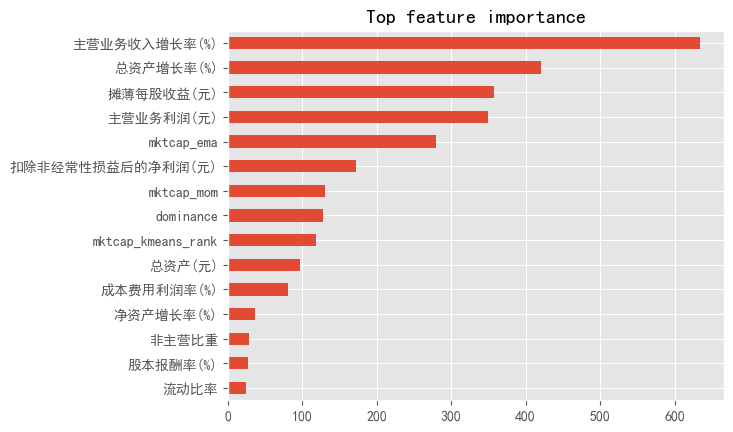

In [43]:
top_features.plot(kind='barh', title='Top feature importance')

In [44]:
from sklearn.metrics import f1_score, accuracy_score

In [45]:
logit = LogisticRegressionCV(penalty="l1", solver="liblinear")

In [46]:
logit.fit(
    first_feature.drop(["y"] + useless_cols.to_list(), axis=1), first_feature["y"]
)

LogisticRegressionCV(penalty='l1', solver='liblinear')

In [47]:
logit.coef_

array([[ 0.        ,  0.        , -0.00166252,  0.0020625 ,  0.        ,
         0.        ,  0.        , -0.0031586 , -0.00171363,  0.        ,
         0.        ,  0.        ,  0.        , -0.0088212 ,  0.        ,
         0.00208183,  0.        , -0.00117162, -0.00194824,  0.        ,
        -0.0045767 ,  0.01181569,  0.        ,  0.        ,  0.        ,
         0.0035217 , -0.001312  ,  0.        ,  0.00658281, -0.00054101,
         0.        , -0.00125556,  0.        , -0.00084296,  0.        ,
         0.        , -0.00304797,  0.        ,  0.00447212,  0.        ,
         0.        ,  0.00027614, -0.01170282, -0.00689669,  0.        ,
         0.        ,  0.        ,  0.00314584,  0.        ,  0.        ,
         0.00164543,  0.        , -0.00204263,  0.        , -0.00166599,
         0.00090711,  0.        , -0.00167305,  0.00102537,  0.00053013,
        -0.00212527, -0.01004663]])

In [48]:
print('accuracy for logit insample: ',accuracy_score(
    first_feature["y"],
    logit.predict(first_feature.drop(["y"] + useless_cols.to_list(), axis=1)),
))
print('f1 for logit insample: ',f1_score(
    first_feature["y"],
    logit.predict(first_feature.drop(["y"] + useless_cols.to_list(), axis=1)),
))

accuracy for logit insample:  0.9615384615384616
f1 for logit insample:  0.7741935483870968


In [49]:
print('accuracy for logit out-of-sample: ',accuracy_score(
    second_feature["y"],
    logit.predict(second_feature.drop(["y"] + useless_cols.to_list(), axis=1)),
))
print('f1 for logit out-of-sample: ',f1_score(
    second_feature["y"],
    logit.predict(second_feature.drop(["y"] + useless_cols.to_list(), axis=1)),
))

accuracy for logit out-of-sample:  0.9460431654676259
f1 for logit out-of-sample:  0.6341463414634148


In [50]:
print('accuracy for lgbm insample: ',accuracy_score(
    first_feature["y"],
    clf.predict(first_feature.drop(["y"] + useless_cols.to_list(), axis=1)),
))
print('f1 for lgbm insample: ',f1_score(
    first_feature["y"],
    clf.predict(first_feature.drop(["y"] + useless_cols.to_list(), axis=1)),
))

accuracy for lgbm insample:  1.0
f1 for lgbm insample:  1.0


In [51]:
print('accuracy for lgbm out-of-sample: ',accuracy_score(
    second_feature["y"],
    clf.predict(second_feature.drop(["y"] + useless_cols.to_list(), axis=1)),
))
print('f1 for lgbm out-of-sample: ',f1_score(
    second_feature["y"],
    clf.predict(second_feature.drop(["y"] + useless_cols.to_list(), axis=1)),
))

accuracy for lgbm out-of-sample:  0.960431654676259
f1 for lgbm out-of-sample:  0.7555555555555555


In [52]:
combined_first = pd.concat(
    [
        first_feature["y"].rename("true"),
        pd.Series(
            clf.predict(first_feature.drop(["y"] + useless_cols.to_list(), axis=1)),
            index=first_feature.index,
        ).rename("predict"),
    ],
    axis=1,
)

In [53]:
combined_second = pd.concat(
    [
        second_feature["y"].rename("true"),
        pd.Series(
            clf.predict(second_feature.drop(["y"] + useless_cols.to_list(), axis=1)),
            index=second_feature.index,
        ).rename("predict"),
    ],
    axis=1,
)

In [54]:
first_deletion_prediction=[
    x
    for x in first_cur["ric"]
    if x not in combined_first[combined_first.predict == 1].index.to_list()
]

In [55]:
print('predict first deletion',first_deletion_prediction)
print('actual first deletion',first_deletion)

predict first deletion ['600066', '300618', '603906', '688388']
actual first deletion ['600066', '300618', '603906', '688388']


In [56]:
first_addition_prediction=[
    x
    for x in  combined_first[combined_first.predict == 1].index
    if x not in first_cur["ric"].to_list()
]

In [57]:
print('predict first addition',first_addition_prediction)
print('actual first addition',first_addition)

predict first addition ['002738', '002756', '688778']
actual first addition ['688778', '001301', '002738', '002756']


In [58]:
second_deletion_prediction=[
    x
    for x in second_cur["ric"]
    if x not in combined_second[combined_second.predict == 1].index.to_list()
]

In [59]:
print('predict second deletion',second_deletion_prediction)
print('actual second deletion',second_deletion)

predict second deletion ['600110', '600699', '600549', '600884', '002407', '300001', '300035', '300037', '002340', '688116', '301238', '688707', '688778', '688499', '301219', '300432', '603026']
actual second deletion ['300035', '688499']


In [60]:
second_addition_prediction = [
    x
    for x in  combined_second[combined_second.predict == 1].index
    if x not in second_cur["ric"].to_list()
]

In [61]:
print('predict second addition',second_addition_prediction)
print('actual second addition',second_addition)

predict second addition ['002129', '002176', '300274', '600933', '601689', '603290', '688275', '688390']
actual second addition ['688275', '301358']


It's difficult to control prediction exactly 50 names, what we can do is take the prediction addition/deletion for a further screening. It could be done manually or adding some feature like confidence score.

In [62]:
from sklearn.inspection import PartialDependenceDisplay

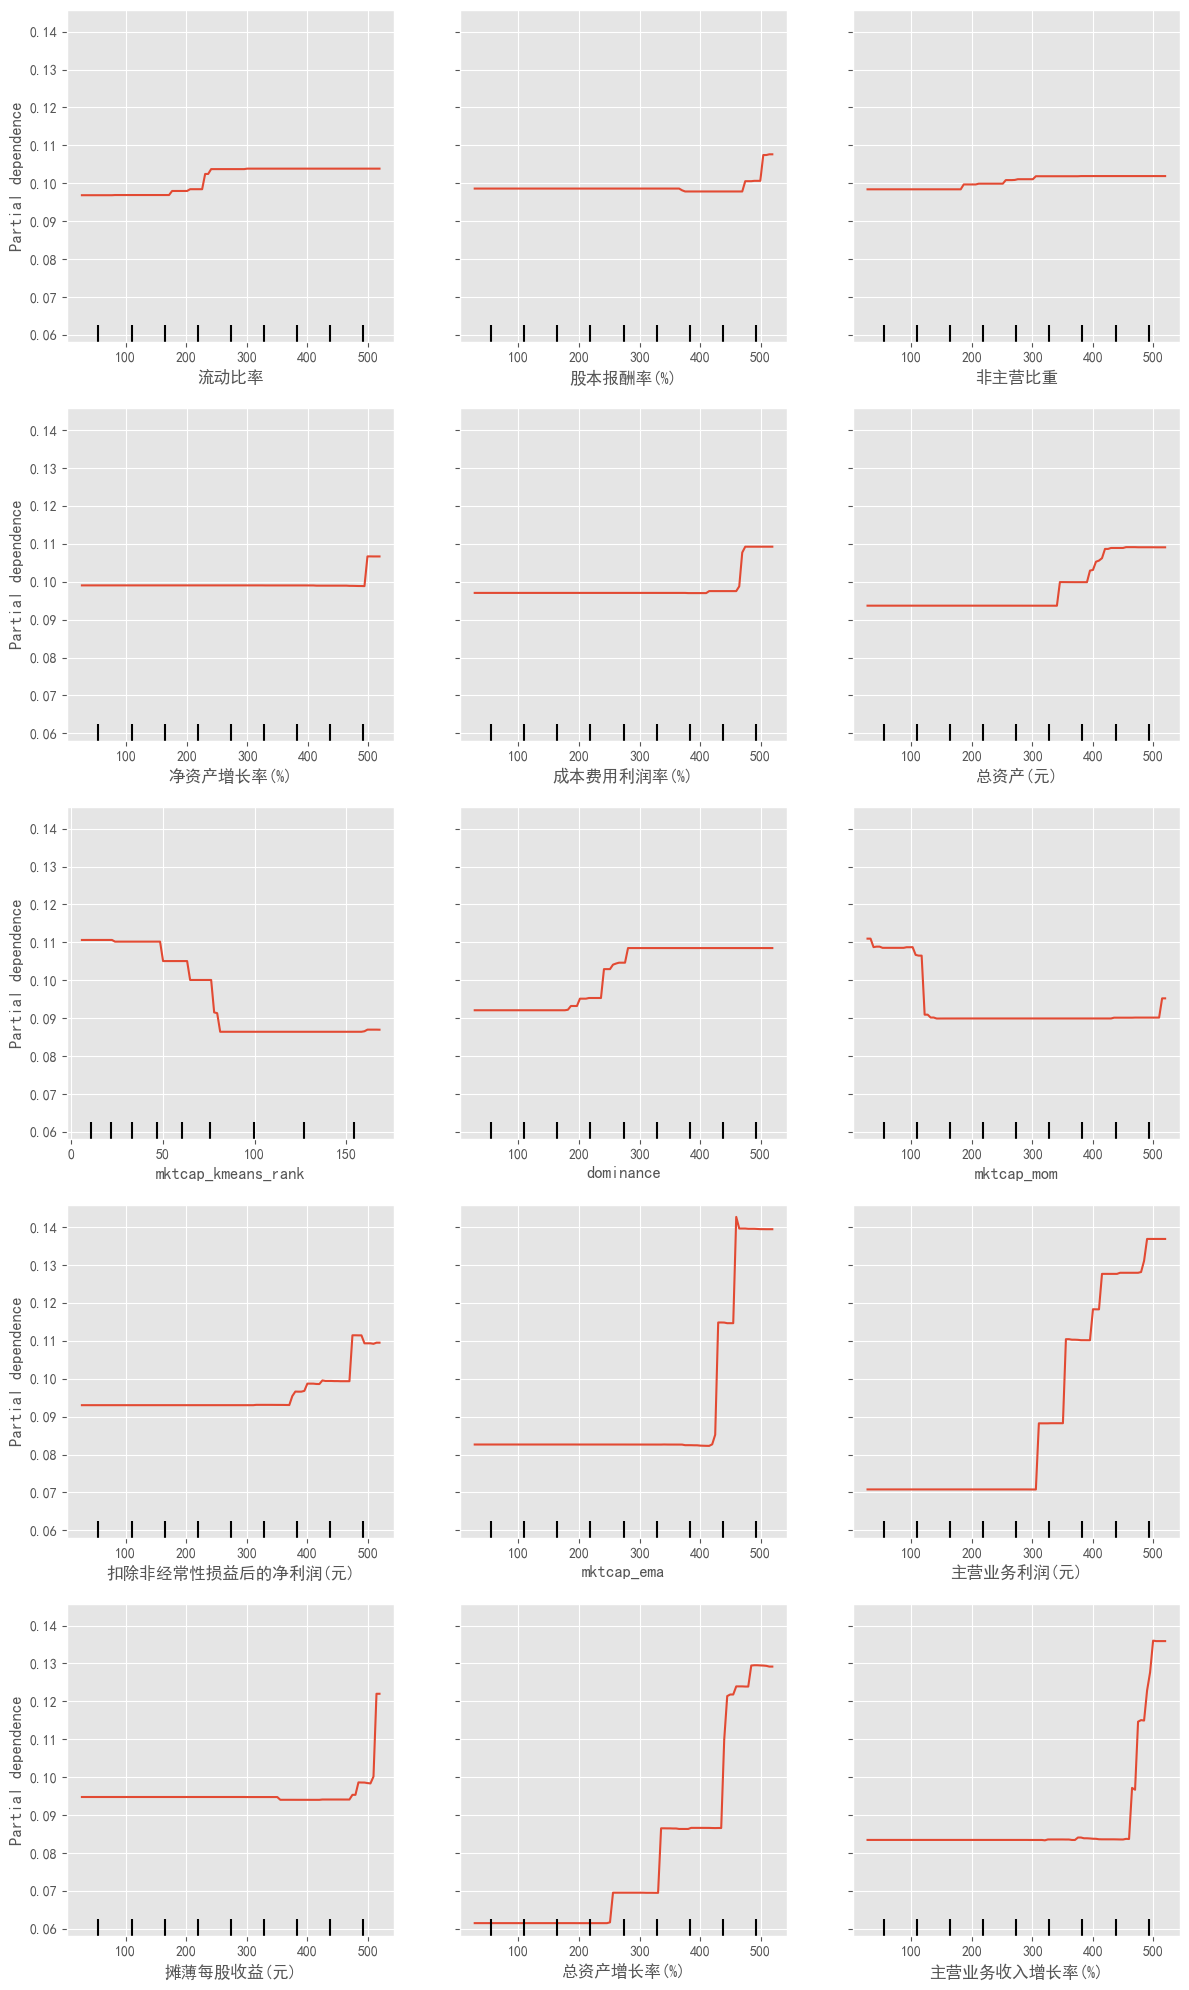

In [63]:
fig, ax = plt.subplots(figsize=(12, 20))
PartialDependenceDisplay.from_estimator(
    clf.best_estimator_,
    first_feature.drop(["y"] + useless_cols.to_list(), axis=1),
    top_features.index,
    ax=ax,
)
plt.tight_layout()

The dependency plot is suggesting growing company are more likely to be selected into the index.

## Strategy Backtest
We go long for addition and short for deletion, the entry point is cruical here and we have 3 options: current, announcement or implementation.

We plot the before/after event return to show the prefet point.

In [64]:
ret = data.reset_index().set_index(["date", "ric"])["close"].unstack().pct_change()

In [65]:
ret.index = pd.to_datetime(ret.index)

In [66]:
ret_excess = ret.subtract(index_ret, axis=0)

In [67]:
def eventret(name, date):
    idx = ret_excess.index.tolist().index(date)
    sub_ret = ret_excess[name].iloc[idx - 14 : idx + 15]
    event_ret = {"e+0": 0}
    for i in range(1, 15):
        event_ret[f"e+{i}"] = event_ret[f"e+{i-1}"] + sub_ret.iloc[13 + i]
        event_ret[f"e-{i}"] = (
            (event_ret[f"e-{i-1}"] - sub_ret.iloc[14 - i])
            if i > 1
            else -sub_ret.iloc[13]
        )

    s = pd.Series(event_ret)
    s = s.reindex(sorted(s.index.tolist(), key=lambda x: int(x[1:])))
    return s

In [68]:
first_dates = {
    "current": pd.to_datetime("2023-04-28"),
    "announcement": pd.to_datetime("2023-05-29"),
    "implement": pd.to_datetime("2023-06-09"),
}
second_dates = {
    "current": pd.to_datetime("2023-10-31"),
    "announcement": pd.to_datetime("2023-11-24"),
    "implement": pd.to_datetime("2023-12-08"),
}

In [70]:
summary = {}
for date in ["current", "announcement", "implement"]:
    for action in ["addition", "deletion"]:
        first_names = eval(f"first_{action}")
        second_names = eval(f"second_{action}")
        eret_summary = []
        for name in first_names:
            eret_summary.append(eventret(name, first_dates[date]).rename(name))

        for name in second_names:
            eret_summary.append(eventret(name, second_dates[date]).rename(name))

        summary[f"{date}_{action}"] = pd.concat(eret_summary, axis=1)

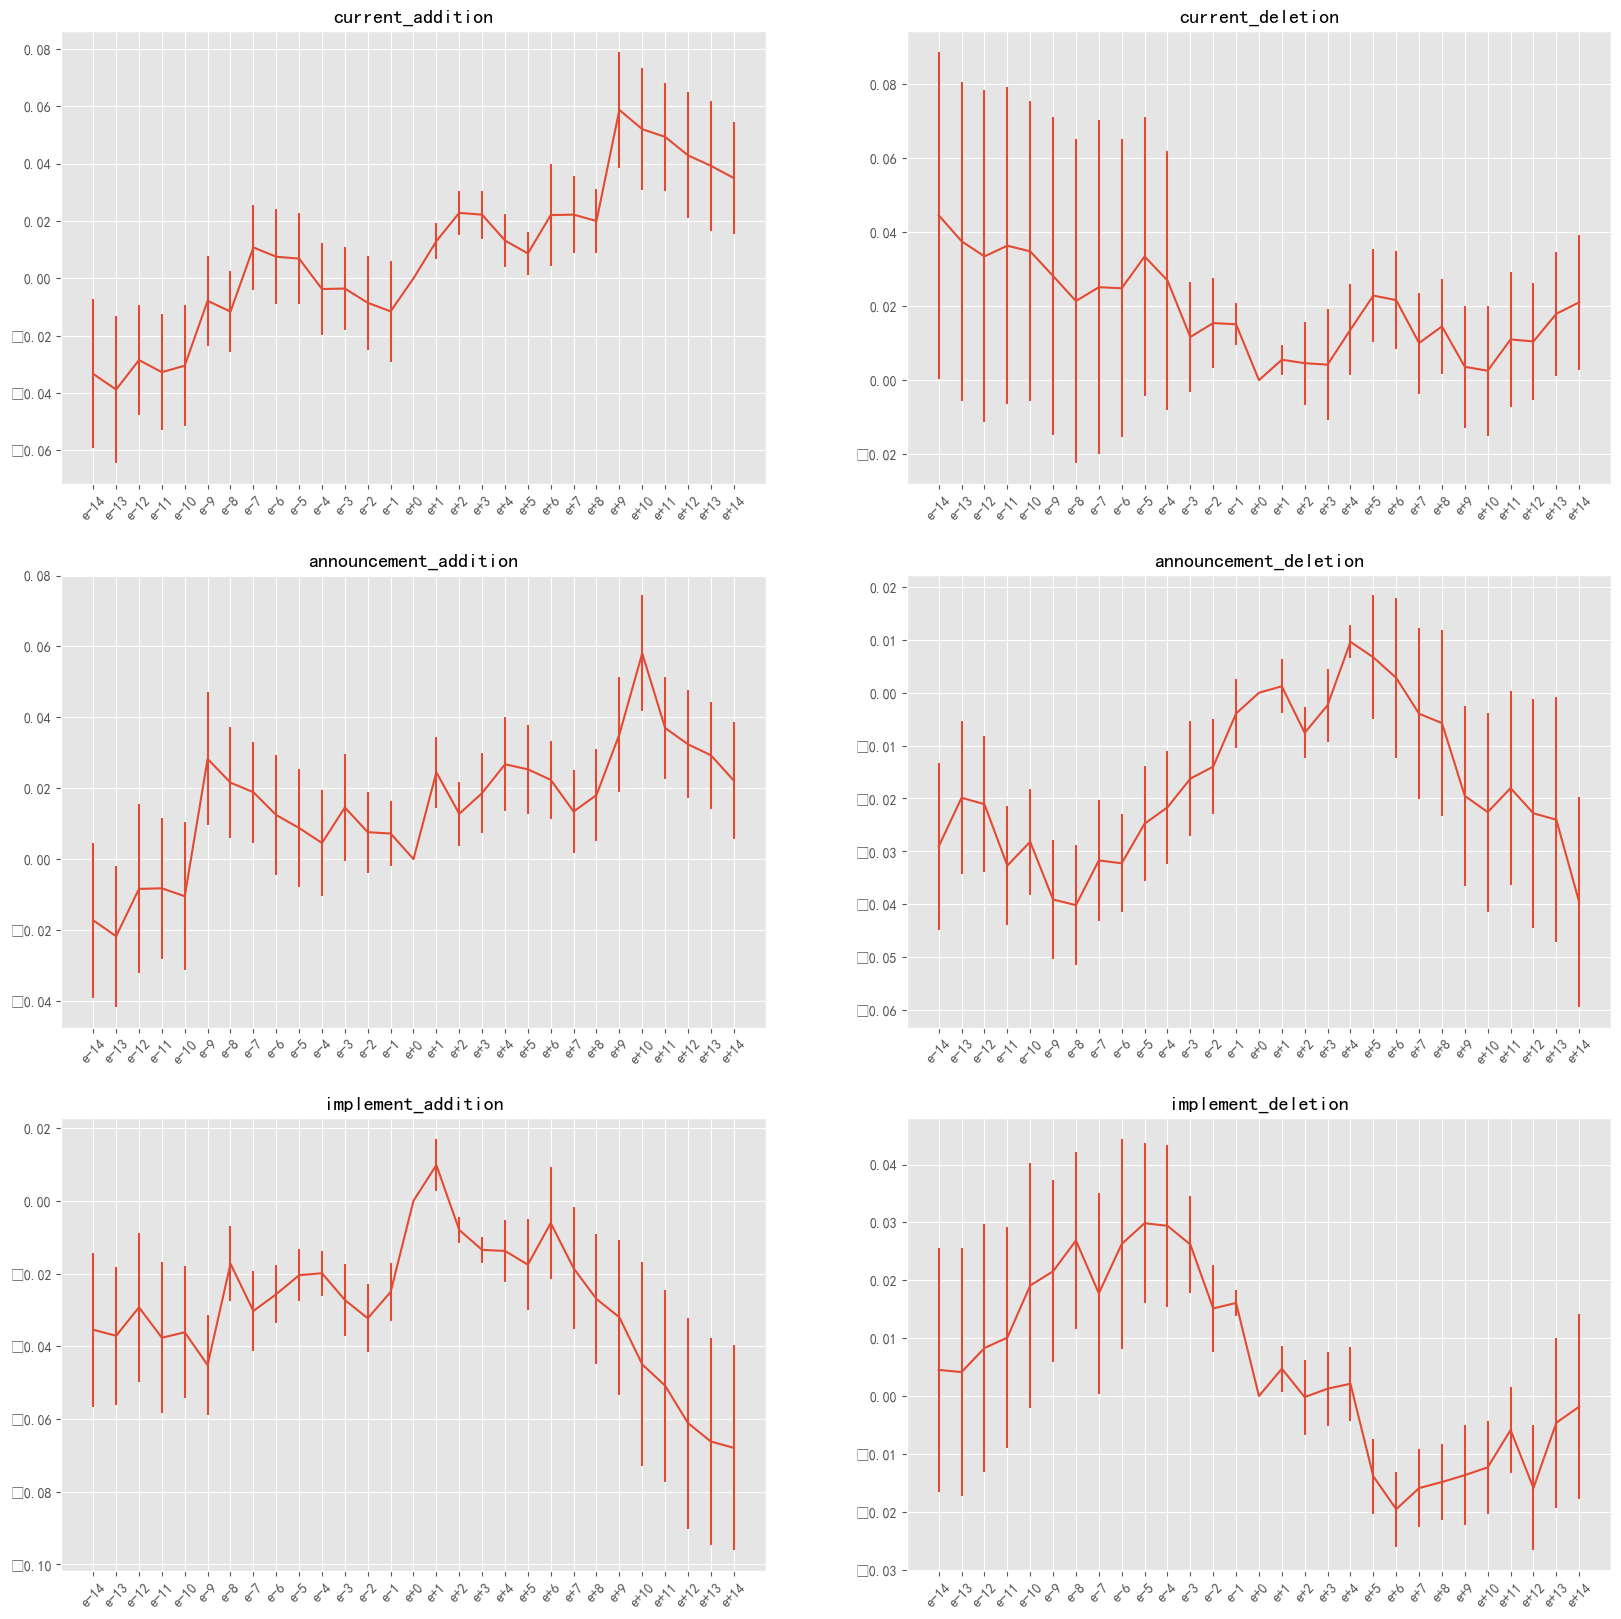

In [71]:
fig, _ = plt.subplots(3, 2, figsize=(20, 20))
summary_keys = list(summary.keys())
summary_values = list(summary.values())
for i, ax in enumerate(fig.axes):
    mean = summary_values[i].mean(1)
    std = summary_values[i].std(1) / np.sqrt(summary_values[i].shape[1])
    mean.plot(xticks=range(len(mean)), rot=45, yerr=std, title=summary_keys[i], ax=ax)

For addition, the information will be priced in before announcement, we could find an uptrend before announcement and a downtrend after implementation.

For deletion, the price will react slower than addition that after announcement, the price starts to go down.

Such event plot suggesting that we could take the addition prediction at current time, and long the prediction addition. Or we could wait until implementation, and short the know addition. For deletion, the post event return is nor significant so we could take prediction.

In [72]:
summary = {}
for date in ["current", "announcement", "implement"]:
    for action in ["addition", "deletion"]:
        first_names = eval(f"first_{action}_prediction")
        second_names = eval(f"second_{action}_prediction")
        eret_summary = []
        for name in first_names:
            eret_summary.append(eventret(name, first_dates[date]).rename(name))

        for name in second_names:
            eret_summary.append(eventret(name, second_dates[date]).rename(name))

        summary[f"{date}_{action}"] = pd.concat(eret_summary, axis=1)

Text(0.5, 0.98, 'Event plot for prediction')

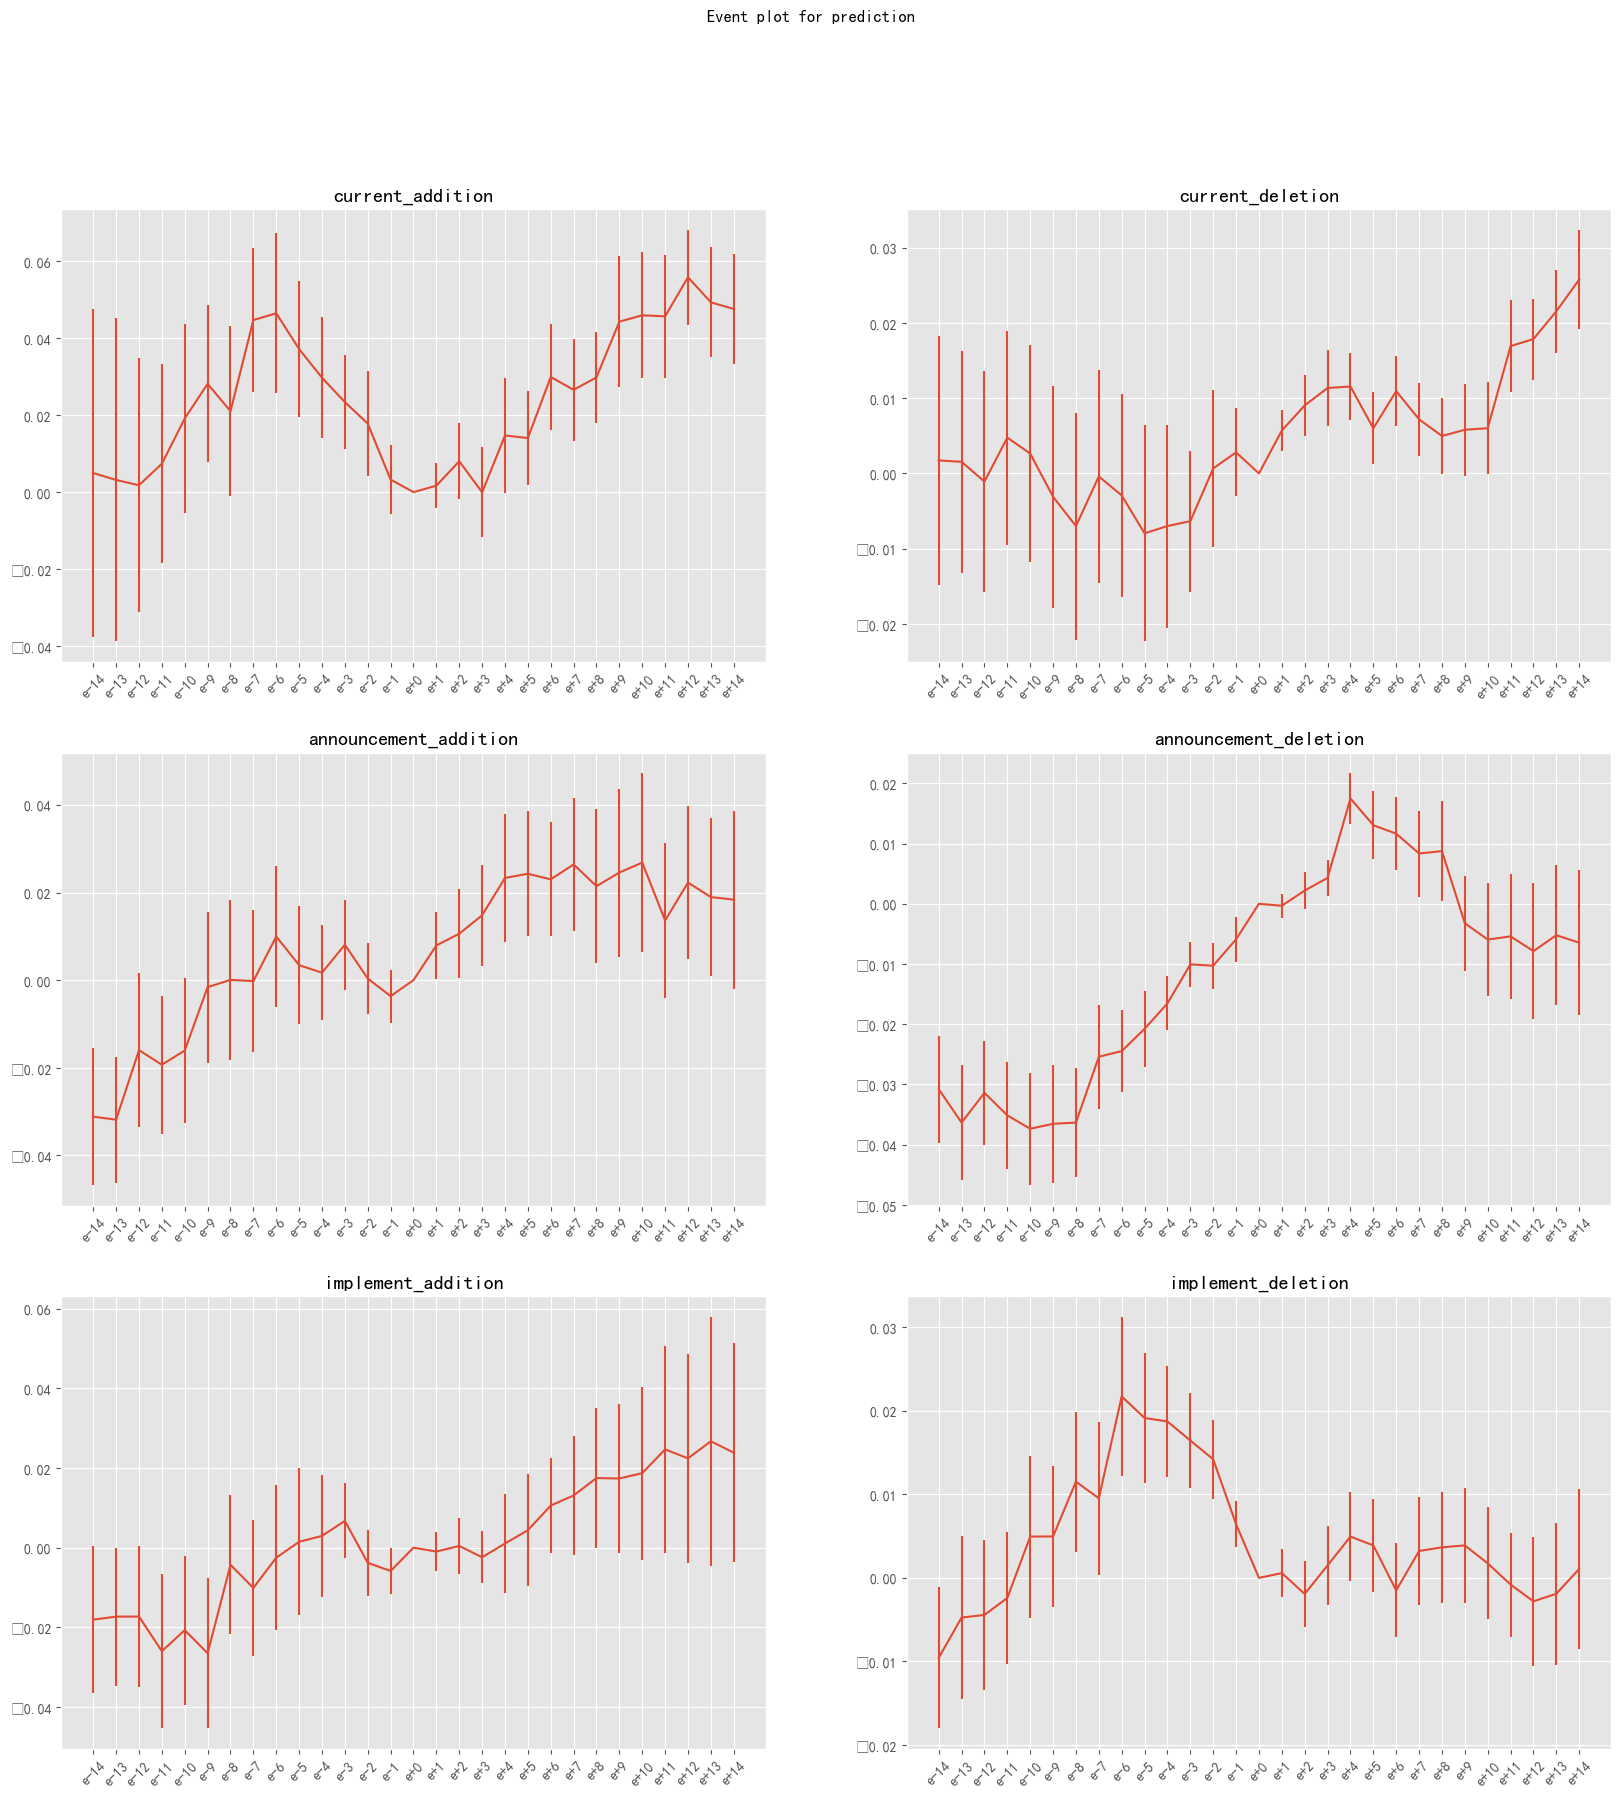

In [73]:
fig, _ = plt.subplots(3, 2, figsize=(20, 20))
summary_keys = list(summary.keys())
summary_values = list(summary.values())
for i, ax in enumerate(fig.axes):
    mean = summary_values[i].mean(1)
    std = summary_values[i].std(1) / np.sqrt(summary_values[i].shape[1])
    mean.plot(xticks=range(len(mean)), rot=45, yerr=std, title=summary_keys[i], ax=ax)

plt.suptitle('Event plot for prediction')

Suppose we change the true addition/deletion to predictions. The plot is suggesting at current time before announcement, we can go long for both addition and deletion, the holding period for addition is longer like 28 days for addition and 18 days for deletion.